In [1]:
import xarray
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

In [2]:
# open dataset
hubv = xarray.open_dataset("hubbard.nc")

In [3]:
t0 = np.datetime64("2017-09-01")
t1 = np.datetime64("2018-10-01")
mask = np.logical_and(hubv.time > t0, hubv.time < t1)


ns_in_day = 60*60*24*1e9
epoch = np.datetime64("2018-01-01")
t = ((hubv.time[mask]-epoch).to_numpy()/ns_in_day).astype(np.float32)


amp0 = np.zeros((hubv.speed.shape[1], hubv.speed.shape[2]))
amp1 = np.zeros((hubv.speed.shape[1], hubv.speed.shape[2]))
phase0 = np.zeros((hubv.speed.shape[1], hubv.speed.shape[2]))
phase1 = np.zeros((hubv.speed.shape[1], hubv.speed.shape[2]))

amp0[:] = np.nan
amp1[:] = np.nan
phase0[:] = np.nan
phase1[:] = np.nan


# Fit smooth function to data and identify peaks
for i in tqdm(range(hubv.speed.shape[1])):
    for j in range(hubv.speed.shape[2]):
        #i = 60
        #j = 60
        
        v = hubv.speed[mask,i,j]
        ti = np.linspace(np.min(t), np.max(t), 1000)

        # Cubic spline
        #cs = scipy.interpolate.CubicSpline(t, v)
        #vi = cs(tp)
        
        # Polynomial fit
        m = np.polyfit(t, v, 8)
        vi = np.polyval(m, ti)
        
        pk = scipy.signal.find_peaks(vi, width=80)[0]
        #break
        if(len(pk) == 1):
            amp0[i,j] = vi[pk[0]]
            phase0[i,j] = ti[pk[0]]
            continue
        elif(len(pk) == 2):
            amp0[i,j] = vi[pk[0]]
            phase0[i,j] = ti[pk[0]]
            amp1[i,j] = vi[pk[1]]
            phase1[i,j] = ti[pk[1]]
            continue
            
#plt.plot(t, v, "ko-")
#plt.plot(ti, vi, "g-")
#plt.plot(ti[pk], vi[pk], "ro")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166/166 [00:36<00:00,  4.57it/s]


In [4]:
# Mask for areas without double peak
mask = np.logical_and(np.logical_not(np.isnan(amp0)), np.logical_not(np.isnan(amp1))).reshape(amp0.shape)

amp0[np.logical_not(mask)] = np.nan
amp1[np.logical_not(mask)] = np.nan
phase0[np.logical_not(mask)] = np.nan
phase1[np.logical_not(mask)] = np.nan

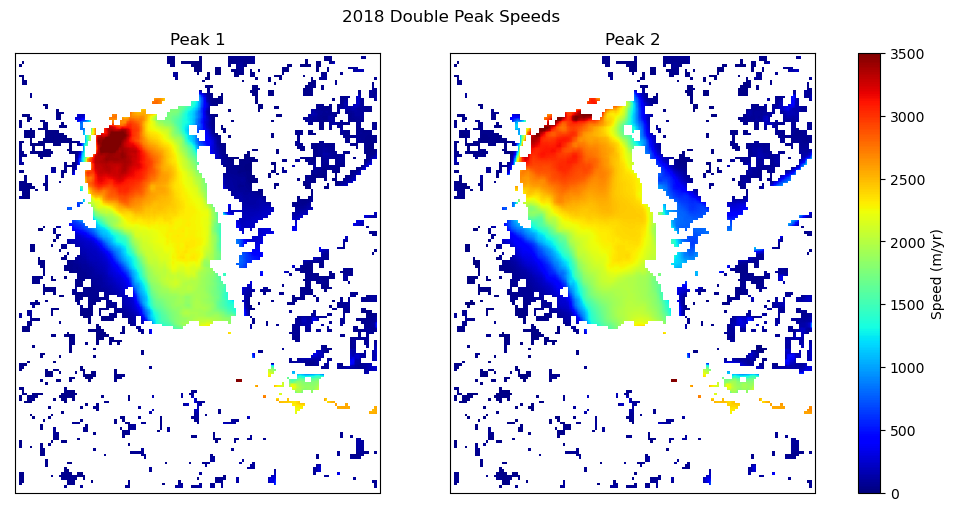

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
axs[0].imshow(amp0, vmin=0, vmax=3500, cmap="jet")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Peak 1")

im = axs[1].imshow(amp1, vmin=0, vmax=3500, cmap="jet")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Peak 2")

fig.suptitle("2018 Double Peak Speeds")
fig.colorbar(im, label="Speed (m/yr)",  ax=axs[:])
plt.savefig("2018_Hubbard_DoublePeak_Amplitude.pdf", bbox_inches="tight")


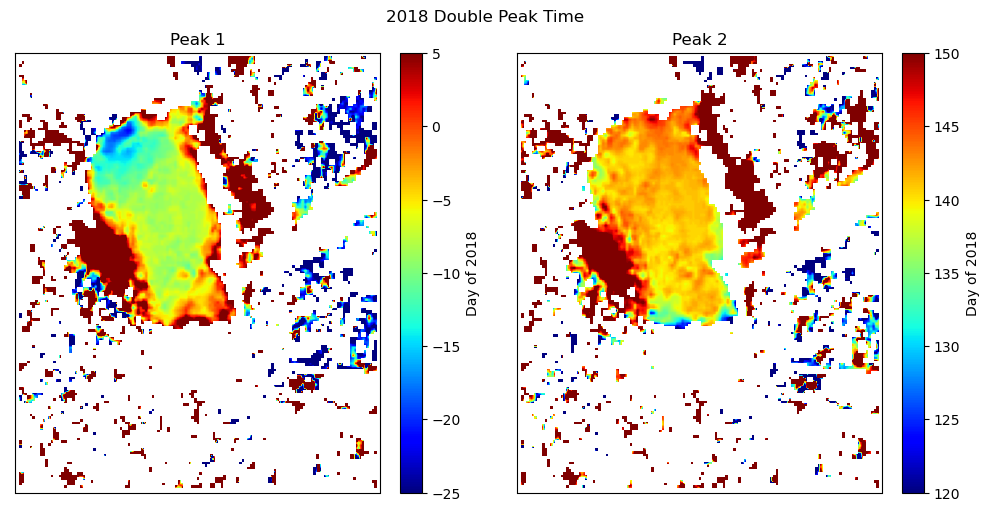

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
im0 = axs[0].imshow(phase0, vmin=-25, vmax=5, cmap="jet")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Peak 1")

im1 = axs[1].imshow(phase1, vmin=120, vmax=150, cmap="jet")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Peak 2")

fig.suptitle("2018 Double Peak Time")
fig.colorbar(im0, label="Day of 2018",  ax=axs[0])
fig.colorbar(im1, label="Day of 2018",  ax=axs[1])
plt.savefig("2018_Hubbard_DoublePeak_Time.pdf", bbox_inches="tight")
